In [65]:
!python -V


Python 3.8.16


In [66]:
!pip install pyarrow


In [68]:
import pickle
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error


In [69]:
def read_dataframe_unfiltered(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df


## Homework

The goal of this homework is to train a simple model for predicting the duration of a ride - similar to what we did in this module.


## Q1. Downloading the data

We'll use [the same NYC taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page),
but instead of "**Green** Taxi Trip Records", we'll use "**Yellow** Taxi Trip Records".

Download the data for January and February 2022.

Read the data for January. How many columns are there?

# Ans: 19


In [70]:
df_jan_unfiltered = read_dataframe_unfiltered('../data/yellow_tripdata_2022-01.parquet')
df_jan_unfiltered.shape[1]-1 # as we are adding "duration" column


19

## Q2. Computing duration

Now let's compute the `duration` variable. It should contain the duration of a ride in minutes.

What's the standard deviation of the trips duration in January?
 
 # Ans: 46.45


In [71]:
std_dev = df_jan_unfiltered['duration'].std()
std_dev

46.44530513776499

## Q3. Dropping outliers

Next, we need to check the distribution of the `duration` variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?


# Ans:  98%

In [ ]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df


In [73]:
# careate function to read data of specific month based on the month name 
# e.g df_jan = read_dataframe(../data/yellow_tripdata_2022-01.parquet)
# e.g df_feb = read_dataframe(../data/yellow_tripdata_2022-02.parquet)
df_jan = read_dataframe('../data/yellow_tripdata_2022-01.parquet')
df_feb = read_dataframe('../data/yellow_tripdata_2022-02.parquet')

In [74]:
# get no of row from the dataframe
df_jan.shape[0]/df_jan_unfiltered.shape[0]*100

98.27547930522405

## Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model. 

* Turn the dataframe into a list of dictionaries
* Fit a dictionary vectorizer 
* Get a feature matrix from it

What's the dimensionality of this matrix (number of columns)?

# Ans: 515


In [76]:
categorical = [ 'PULocationID', 'DOLocationID']
# numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_jan[categorical ].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)


X_train.shape[1]

515

## Q5. Training a model

Now let's use the feature matrix from the previous step to train a model. 

* Train a plain linear regression model with default parameters 
* Calculate the RMSE of the model on the training data

What's the RMSE on train?

# Ans: 6.99

In [77]:
target = 'duration'
y_train = df_jan[target].values

In [78]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

6.986190688113568

## Q6. Evaluating the model

Now let's apply this model to the validation dataset (February 2022). 

What's the RMSE on validation?

# Ans: 7.79

In [79]:

val_dicts = df_feb[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)
target = 'duration'
y_val = df_feb[target].values

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)


7.786412143012353

# Experimenting with the model graphical output  (not included in the homework)

/tmp/ipykernel_11095/437147669.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_11095/437147669.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


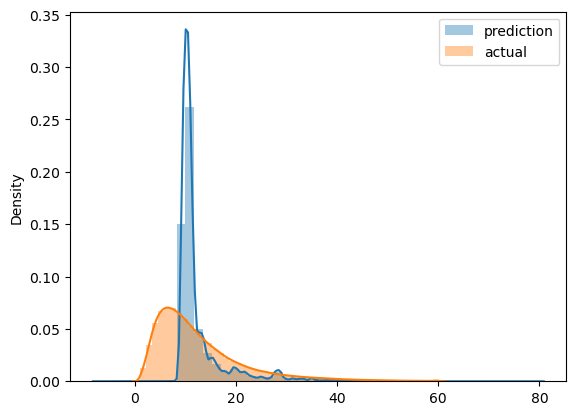

In [80]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()


# github link: https://github.com/Avyukth/mlops-dtc